## This notebook shows how to design synthetic sequences by using in silico evolution.

#### It consists of:
*		Generating GC-adjusted random sequences:
*		Performing in silico evolution and random drift experiments.
*		Plotting the findings.
*		Printing generated DNA sequences in nucleotide letters.

#### Luciferase values are in ./data/luciferase folder
#### Intermediate files are saved to ./data/deepmel2 folder
#### Figures are saved to ./figures/evolution_from_scratch

### General imports¶


In [1]:
import sys  
import os
import pickle
import utils
import numpy as np
import scipy
import tensorflow as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("default")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Loading DeepMEL2 data to be used for the initialization of shap.DeepExplainer


In [2]:
print('Loading data...')
f = open('./data/deepmel2/DeepMEL2_nonAugmented_data.pkl', "rb")
nonAugmented_data_dict = pickle.load(f)
f.close()

Loading data...


### Loading the models and initializing shap.DeepExplainer

In [3]:
print('Loading model...')
import shap
tf.disable_eager_execution()
rn=np.random.choice(nonAugmented_data_dict["train_data"].shape[0], 250, replace=False)
model_dict = {}
exp_dict = {} 

name = "deepmel2"
model_json_file = "models/deepmel2/model.json"
model_hdf5_file = "models/deepmel2/model_epoch_07.hdf5"
model_dict[name] = utils.load_model(model_json_file, model_hdf5_file)
exp_dict[name] = shap.DeepExplainer((model_dict[name].inputs, model_dict[name].layers[-1].output), [nonAugmented_data_dict["train_data"][rn],nonAugmented_data_dict["train_data"][rn][:,::-1,::-1]])


name = "deepmel2_gabpa"
model_json_file = "models/deepmel2_gabpa/model.json"
model_hdf5_file = "models/deepmel2_gabpa/model_epoch_09.hdf5"
model_dict[name] = utils.load_model(model_json_file, model_hdf5_file)
exp_dict[name] = shap.DeepExplainer((model_dict[name].inputs, model_dict[name].layers[-1].output), [nonAugmented_data_dict["train_data"][rn],nonAugmented_data_dict["train_data"][rn][:,::-1,::-1]])


name = "deepmel"
model_json_file = "models/deepmel/model.json"
model_hdf5_file = "models/deepmel/model_best_loss.hdf5"
model_dict[name] = utils.load_model(model_json_file, model_hdf5_file)
exp_dict[name] = shap.DeepExplainer((model_dict[name].inputs, model_dict[name].layers[-1].output), [nonAugmented_data_dict["train_data"][rn],nonAugmented_data_dict["train_data"][rn][:,::-1,::-1]])


Loading model...


In [4]:
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

### This code:
* Takes genomic regions fasta file and creates GC adjusted random sequences
* Performs in silico evolution on random sequences

In [ ]:
# path_to_use_GC_content = "./data/deepmel2/Genomic_MEL_regions.fa"
# number_of_random_regions = 4000
# seq_len = 500

# evolved_seq_4000_dict = {}
# evolved_seq_4000_dict["X"] = utils.random_sequence_gc_adjusted(seq_len, number_of_random_regions, path_to_use_GC_content)

# path_to_save = "data/deepmel2/MM_EFS_4000_withmut.pkl"

# evolved_seq_4000_dict["mut_pred"], \
# evolved_seq_4000_dict["mut_loc"] = utils.insilico_evolution(regions = evolved_seq_4000_dict["X"],
#                                                                 model = model_dict["deepmel2"],
#                                                                 class_no = 16,
#                                                                 n_mutation = 20,
#                                                                 rc = True
#                                                                )
# # save the final file
# import pickle
# f = open(path_to_save, "wb")
# pickle.dump(evolved_seq_4000_dict,f)
# f.close()


In [10]:
import pickle
f = open("data/deepmel2/MM_EFS_4000_withmut.pkl", "rb")
evolved_seq_4000_dict = pickle.load(f)
f.close()

### This code:
* Performs in random drift mutations on the random sequences generated above

In [ ]:
# random_drift_4000_dict = {}
# random_drift_4000_dict["X"] = np.copy(evolved_seq_4000_dict["X"])

# random_drift_4000_dict["mut_pred"], \
# random_drift_4000_dict["mut_loc"] = utils.random_drift(regions = random_drift_4000_dict["X"],
#                                                                 model = model_dict["deepmel2"],
#                                                                 class_no = 16,
#                                                                 n_mutation = 20,
#                                                                 rc = True
#                                                                )
# # save the final file
# import pickle
# f = open(data/deepmel2/MM_RandomDrift_4000_withmut.pkl, "wb")
# pickle.dump(evolved_seq_4000_dict,f)
# f.close()

In [11]:
import pickle
f = open("data/deepmel2/MM_RandomDrift_4000_withmut.pkl", "rb")
random_drift_4000_dict = pickle.load(f)
f.close()

### Reading fasta file

In [35]:
Genomic_MEL = utils.prepare_data("./data/deepmel2/Genomic_MEL_regions.fa")
Genomic_MEL_dict = {"ids":np.array(Genomic_MEL[1]),"X":Genomic_MEL[0]}

### Plotting GC-content comparison of Genomic and GC-adjusted random sequences

Text(0, 0.5, 'Average GC-content')

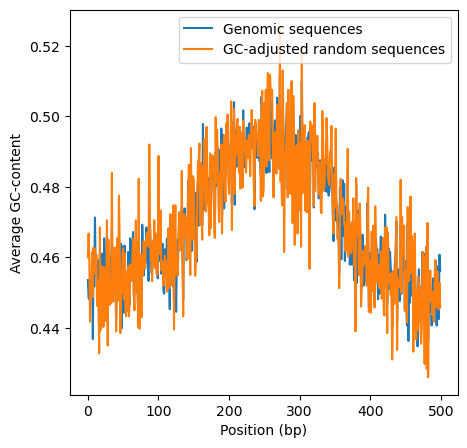

In [44]:
plt.figure(figsize=(5,5,))
plt.plot(np.sum(Genomic_MEL_dict["X"][:,:,1]+Genomic_MEL_dict["X"][:,:,2],axis=0)/len(Genomic_MEL_dict["X"]), label="Genomic sequences")
plt.plot(np.sum(evolved_seq_4000_dict["X"][:,:,1]+evolved_seq_4000_dict["X"][:,:,2],axis=0)/len(evolved_seq_4000_dict["X"]), label="GC-adjusted random sequences")
plt.legend()
plt.xlabel("Position (bp)")
plt.ylabel("Average GC-content")

### Smoothed plotting GC-content comparison of Genomic and GC-adjusted random sequences¶

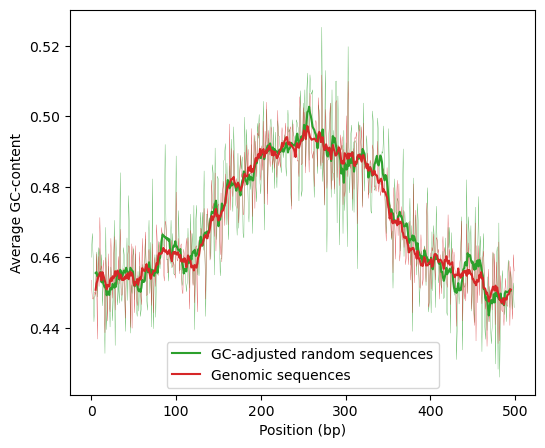

In [52]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

plt.figure(figsize=(6,5))
plt.plot((np.mean(evolved_seq_4000_dict["X"][:,:,1] + evolved_seq_4000_dict["X"][:,:,2],axis=0)),color="C2",linewidth=0.2)
plt.plot((np.mean(Genomic_MEL_dict["X"][:,:,1] + Genomic_MEL_dict["X"][:,:,2],axis=0)),color="C3",linewidth=0.2)

smt_val = 10
plt.plot(range(5,496),smooth(np.mean(evolved_seq_4000_dict["X"][:,:,1] + evolved_seq_4000_dict["X"][:,:,2],axis=0),smt_val),label="GC-adjusted random sequences",color="C2")
plt.plot(range(5,496),smooth(np.mean(Genomic_MEL_dict["X"][:,:,1] + Genomic_MEL_dict["X"][:,:,2],axis=0),smt_val),label="Genomic sequences",color="C3")

plt.legend()
plt.xlabel("Position (bp)")
plt.ylabel("Average GC-content")
plt.savefig("figures/evolution_from_scratch/GC_content_Genomic_vs_Random.pdf",transparent=True)

### Plotting prediction scores at each mutational step for both random drift and directed evolution

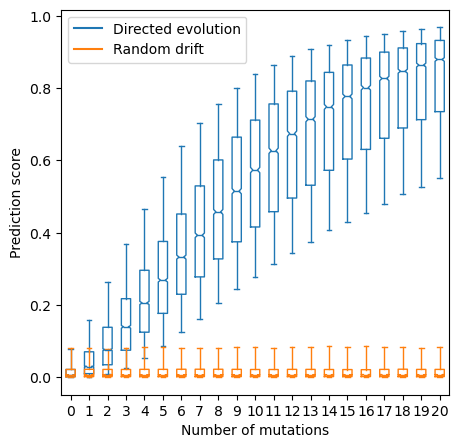

In [25]:
plt.figure(figsize=(5,5))
c="C0"
_ = plt.boxplot(evolved_seq_4000_dict["mut_pred"][:,:,15],notch=True,showfliers=False, whis=[5,95],
                boxprops=dict(color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),
                )
plt.plot([],label="Directed evolution",color="C0")

c="C1"
_ = plt.boxplot(random_drift_4000_dict["mut_pred"][:,:,15],notch=True,showfliers=False, whis=[5,95],
                boxprops=dict(color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),
                )
plt.plot([], label="Random drift",color="C1")

_ = plt.xticks(range(1,22),list(range(21)))
plt.legend()
plt.xlabel("Number of mutations")
plt.ylabel("Prediction score")
plt.savefig("figures/evolution_from_scratch/EFS_vs_RandomDrift_PredistionDist.pdf",transparent=True)

### Plotting prediction scores at each mutational step for selected regions

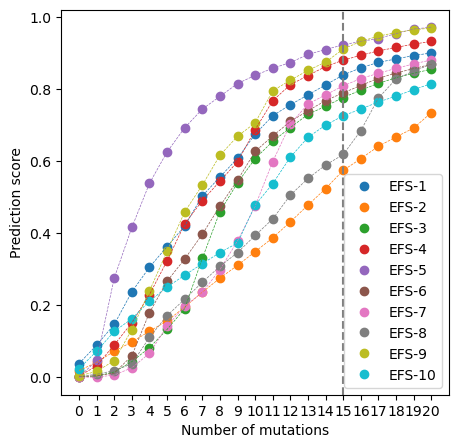

In [27]:
plt.figure(figsize=(5,5))
for k,i in enumerate([15,17,19,22,27,45,49,60,68,72]):
    _ = plt.plot(evolved_seq_4000_dict["mut_pred"][i,:21,15].T,label="EFS-"+str(k+1),linestyle="",marker="o",color="C"+str(k))
plt.legend()
for k,i in enumerate([15,17,19,22,27,45,49,60,68,72]):
    _ = plt.plot(evolved_seq_4000_dict["mut_pred"][i,:21,15].T,label="EFS-"+str(k+1),linestyle="--",linewidth=0.5,color="C"+str(k))
_ = plt.xticks(range(21),list(range(21)))
plt.axvline(x=15,linestyle="--",color="gray")
plt.xlabel("Number of mutations")
plt.ylabel("Prediction score")
plt.savefig("figures/evolution_from_scratch/EFS_SelectedSeqs_Prediction.pdf",transparent=True)

### Loading luciferase data

In [28]:
luciferase_dict = {"ids":[],"values":[]}
with open("data/luciferase/EFSall_IRF4_TYR_MLANA.txt","r") as fr:
    for line in fr:
        if line.startswith("id"):
            continue
        sep = line.strip().split("\t")
        luciferase_dict["ids"].append(sep[0])
        luciferase_dict["values"].append(sep[1:])
luciferase_dict["values"] = np.array(luciferase_dict["values"],dtype="float")

### Plotting luciferase results

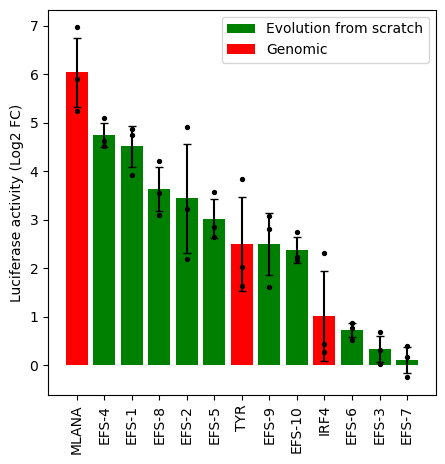

In [30]:
plt.figure(figsize=(5,5))
mean = np.mean(np.log2(luciferase_dict["values"]),axis=1)
std = np.std(np.log2(luciferase_dict["values"]),axis=1)

index = np.argsort(mean)[::-1]
temp = sorted(mean)[::-1]
res = [temp.index(i) for i in mean]

plt.bar(res[:10],mean[:10],color="green",label="Evolution from scratch",yerr=std[:10],capsize=3)
plt.bar(res[10:],mean[10:],color="red",label="Genomic",yerr=std[10:],capsize=3)
plt.legend()

for i in range(13):
    for k in np.log2(luciferase_dict["values"][i]):
        plt.scatter(res[i],k,color="black",zorder=10,s=8)
    
_ = plt.xticks(range(13),np.array(luciferase_dict["ids"])[index],rotation=90)
plt.ylabel("Luciferase activity (Log2 FC)")
plt.savefig("figures/evolution_from_scratch/EFS_SelectedSeqs_luciferase_withdot.pdf",transparent=True)


### Plotting contribution scores of random and fully evolved sequences.

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,

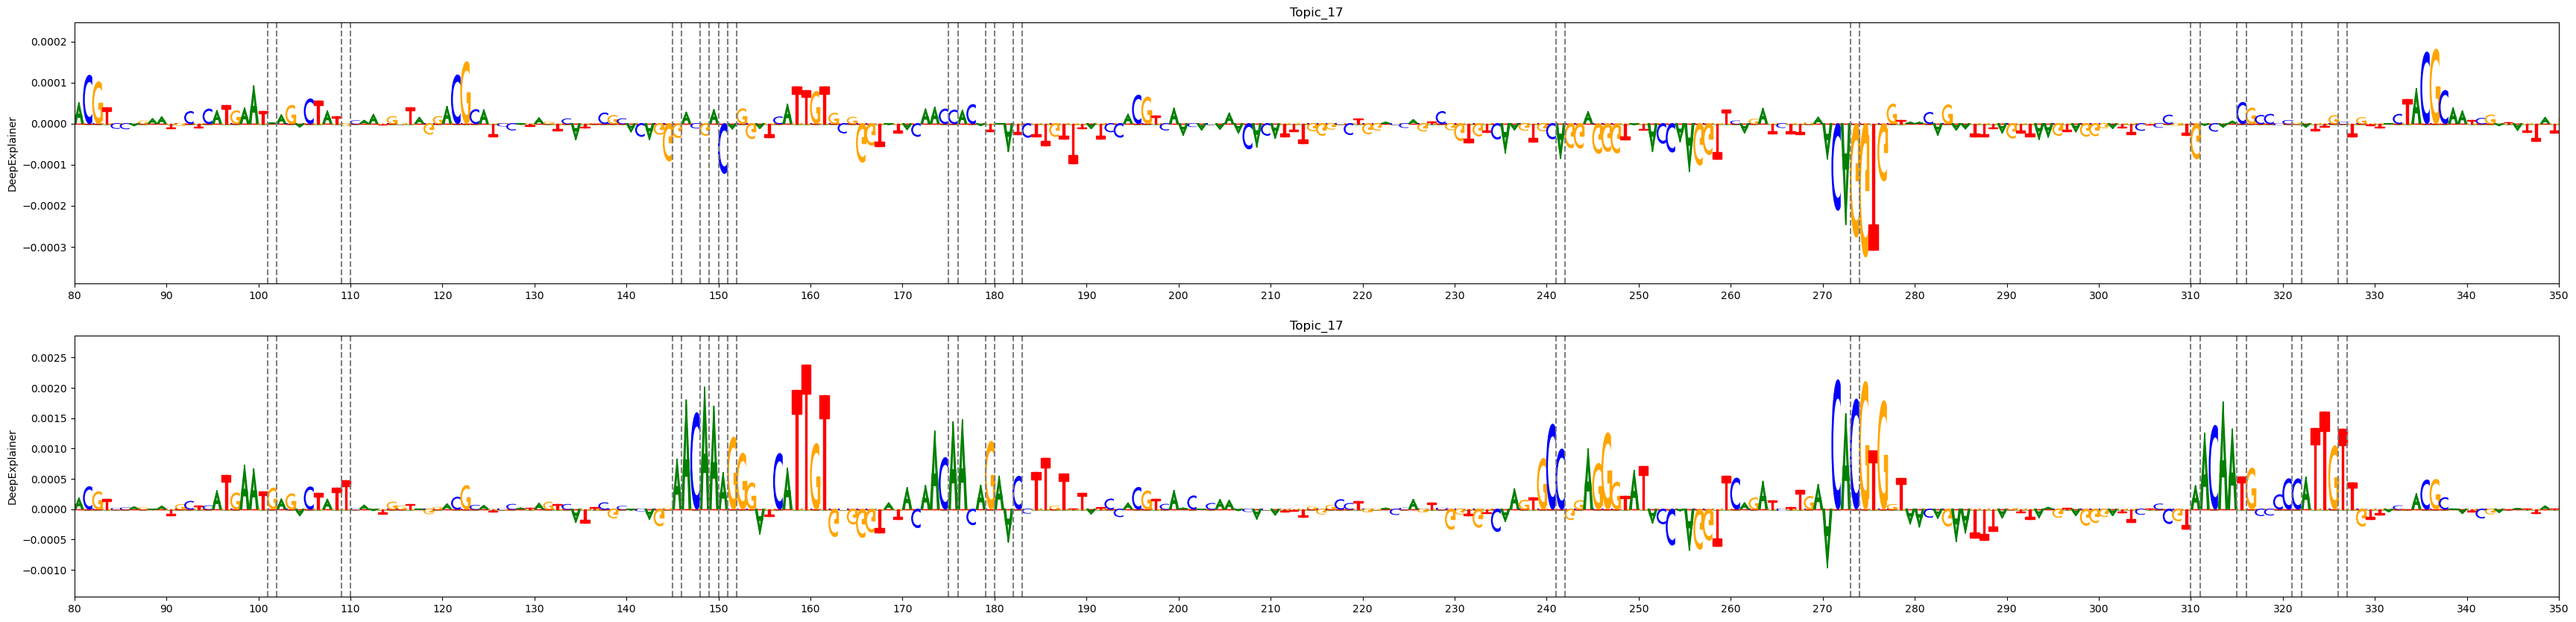

In [32]:
#[15,17,19,22,27,45,49,60,68,72]
id_ = 22
st = 80
end = 350

nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}
start_x = np.copy(evolved_seq_4000_dict["X"][id_:id_+1])

ntrack = 2
fig = plt.figure(figsize=(43,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax_withrc(explainer=exp_dict["deepmel2"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 17)

for i, mut_ in enumerate(evolved_seq_4000_dict["mut_loc"][id_][:15]):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')

ax2 = utils.plot_deepexplainer_givenax_withrc(explainer=exp_dict["deepmel2"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 17)

for i, mut_ in enumerate(evolved_seq_4000_dict["mut_loc"][id_][:15]):
    
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    ax1.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax1.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

ax1.set_xlim([st,end])
ax2.set_xlim([st,end])

plt.savefig("figures/evolution_from_scratch/EFS4_deepexplainer_mut0_mut15_st80_end350.pdf",transparent=True)


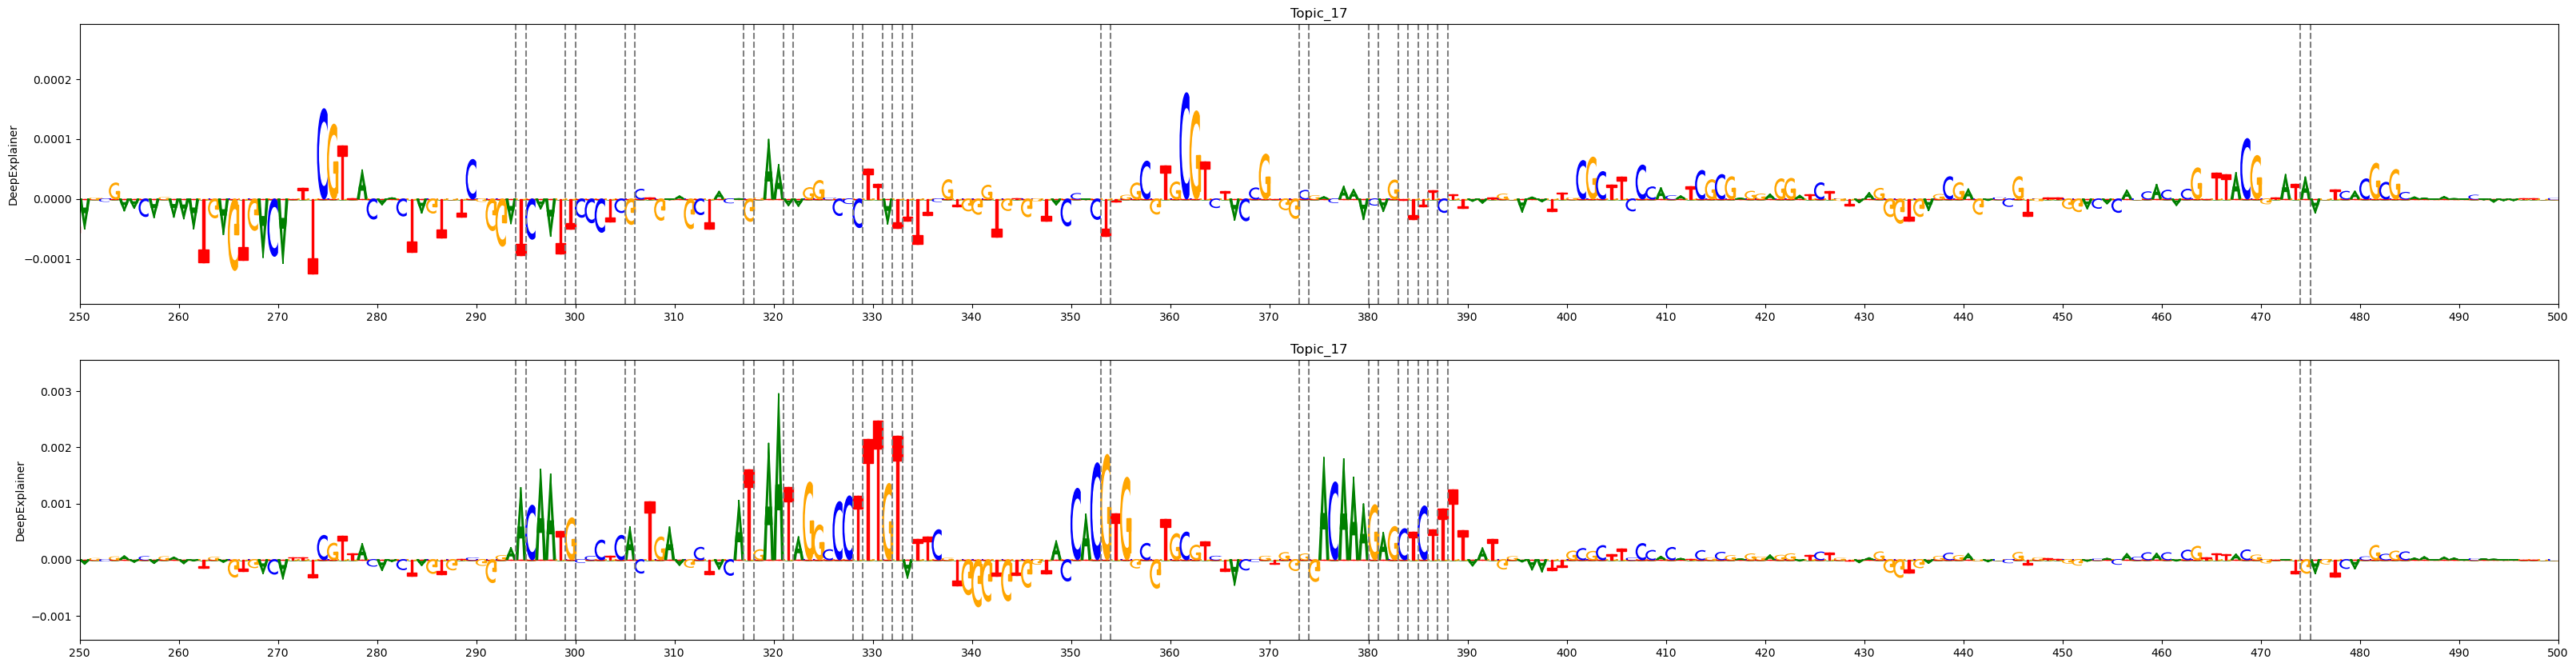

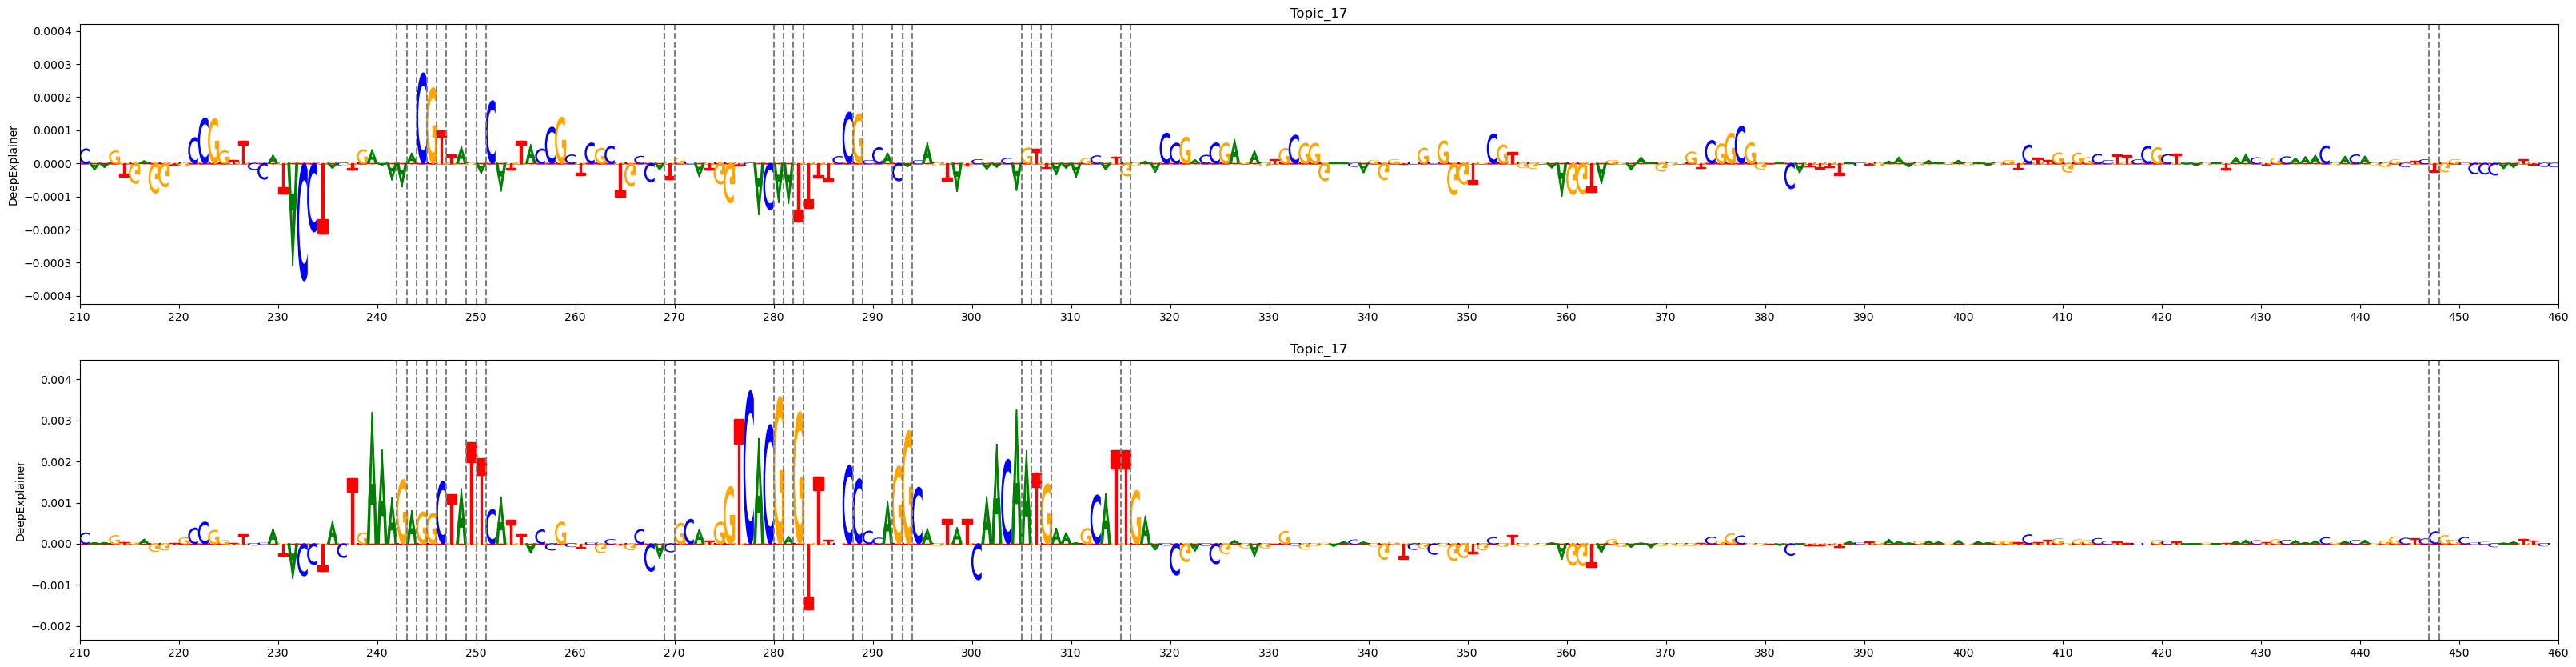

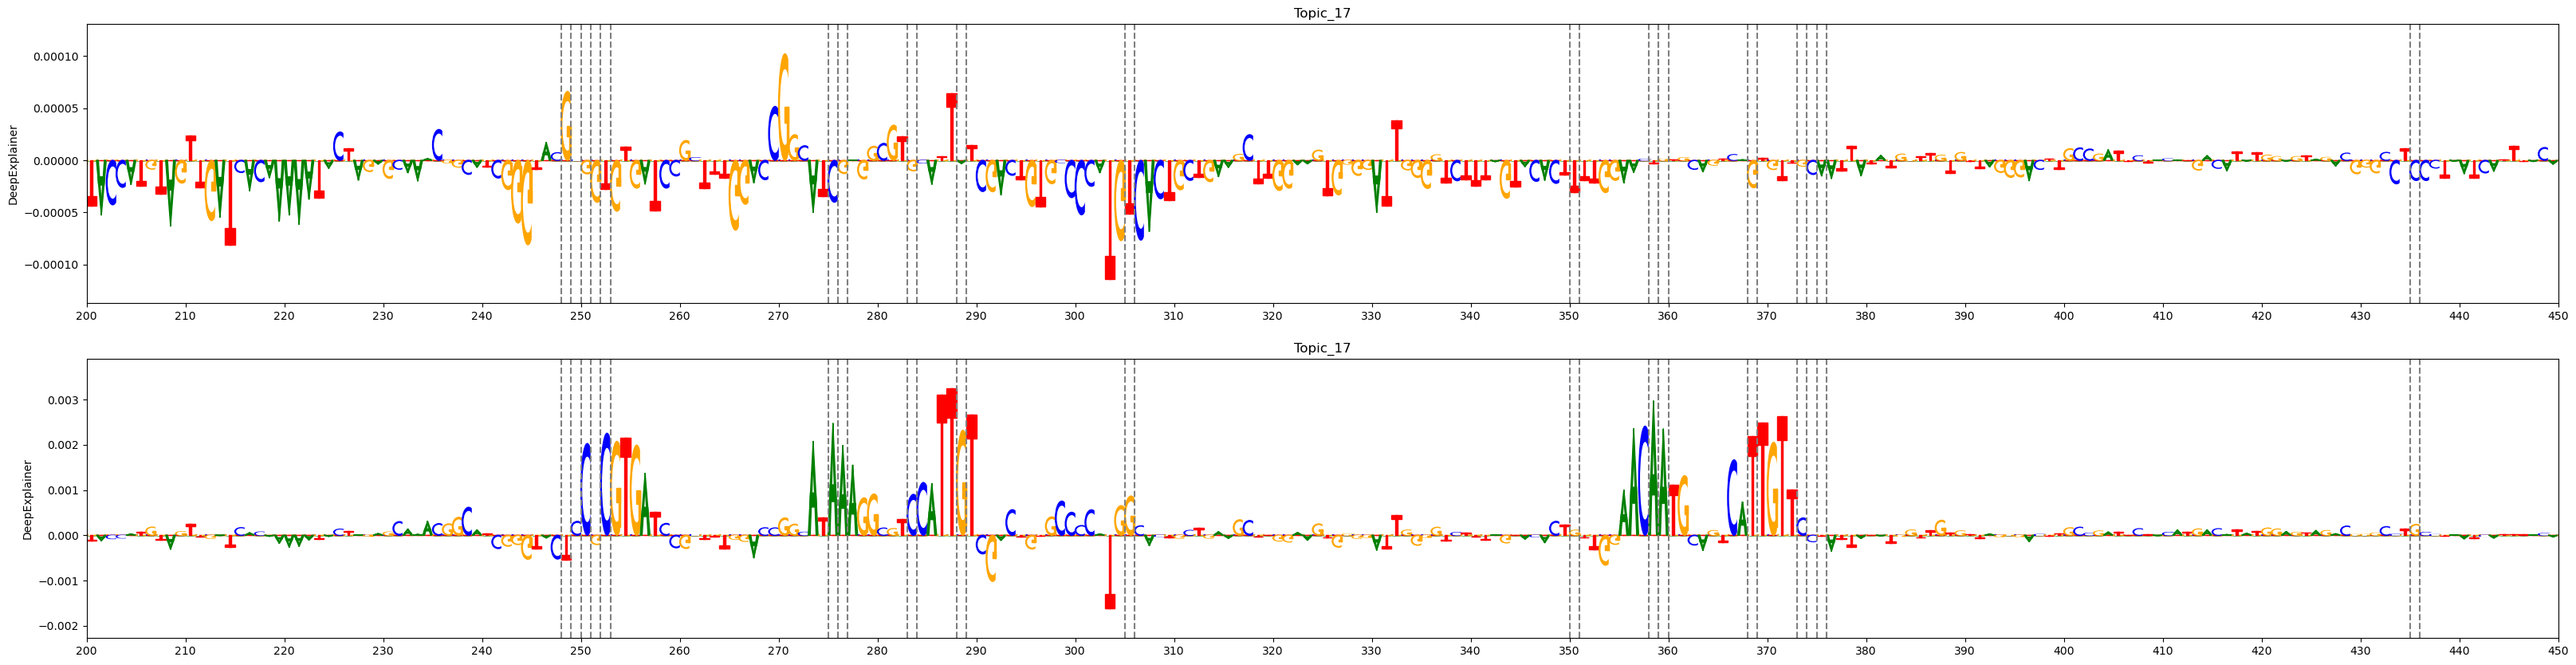

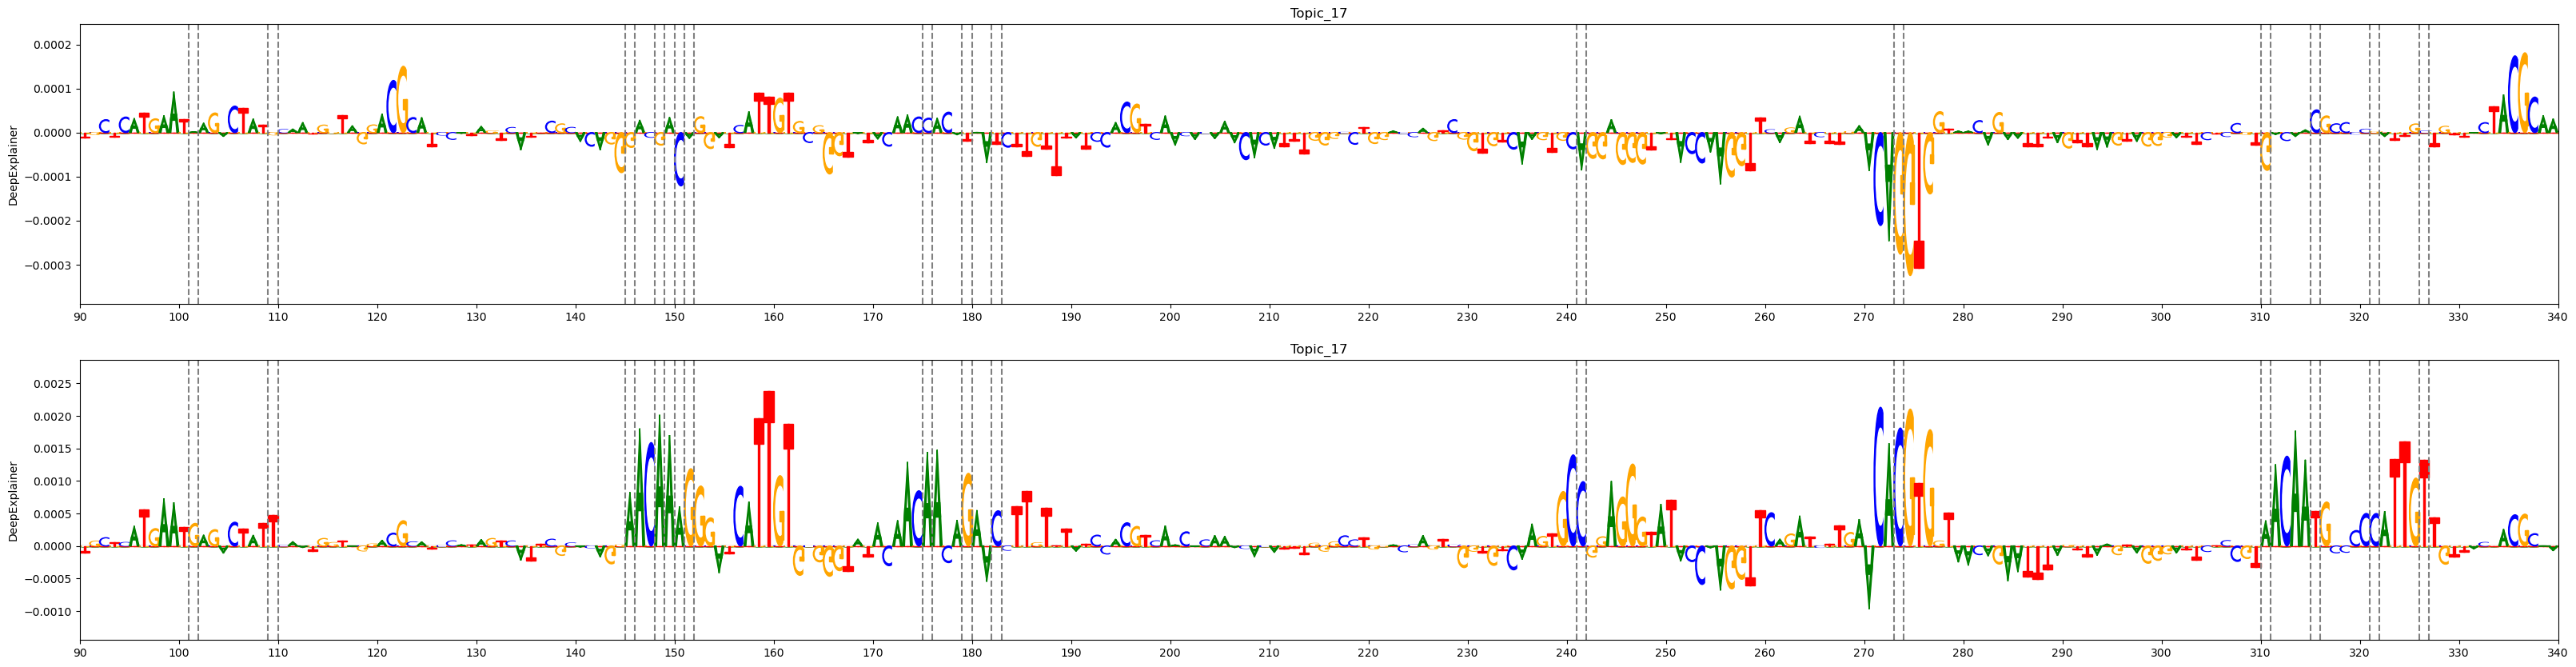

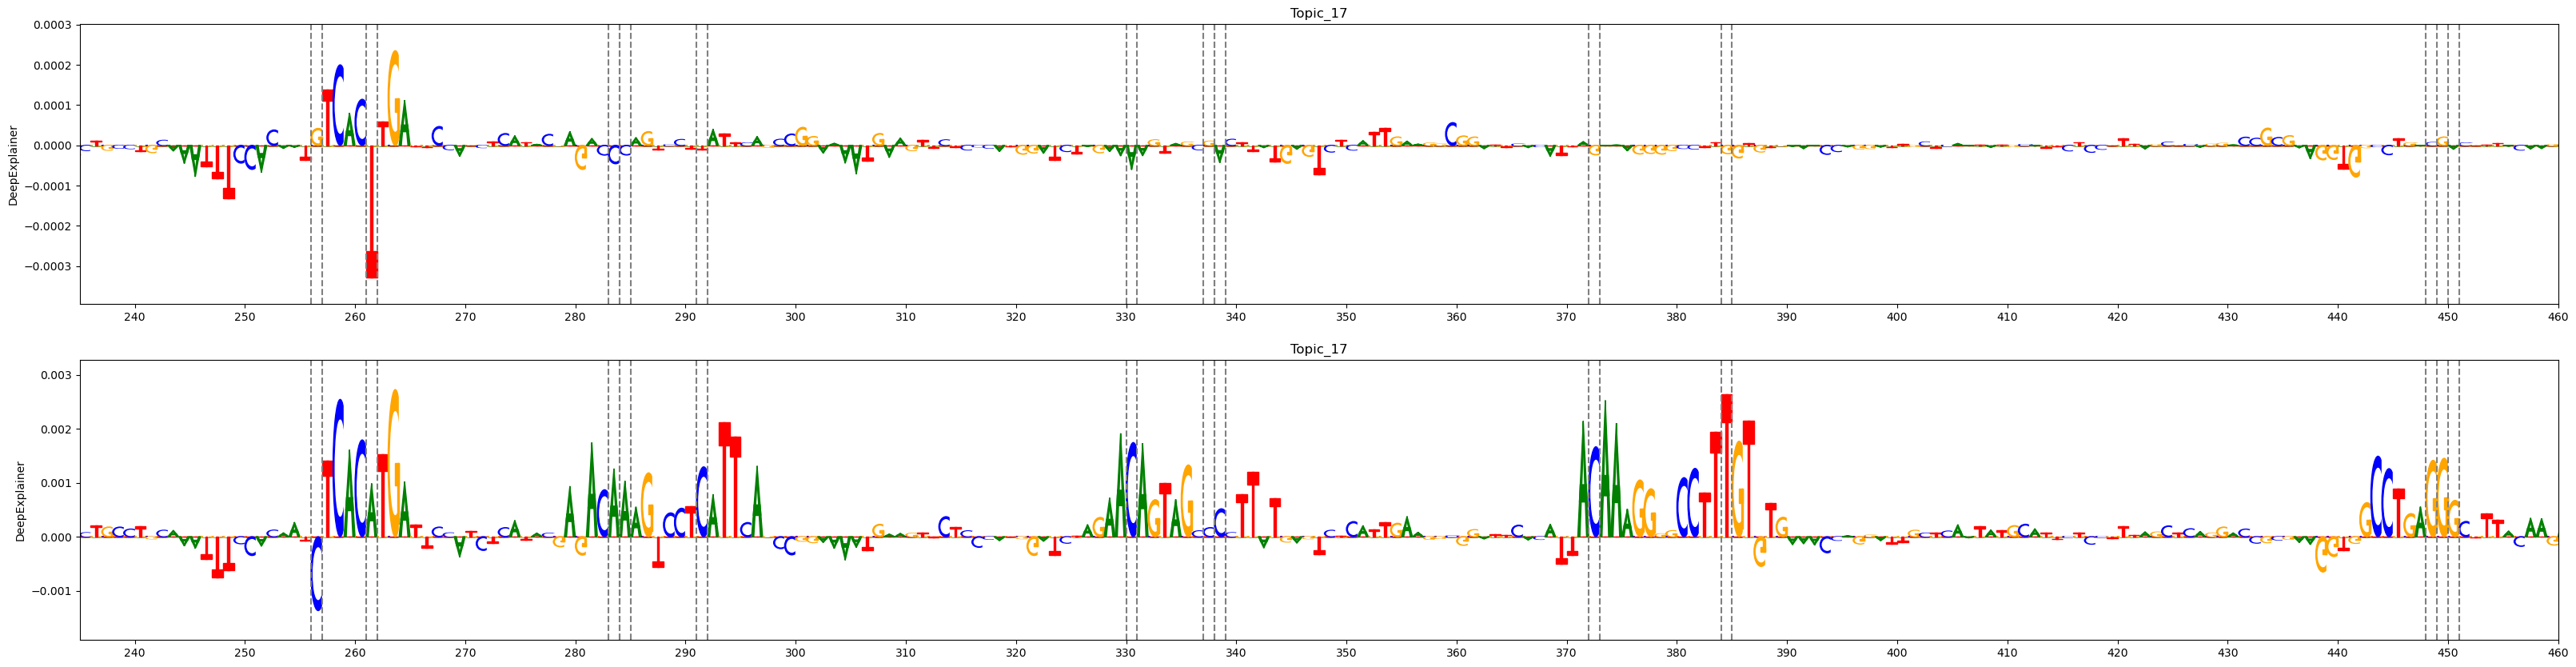

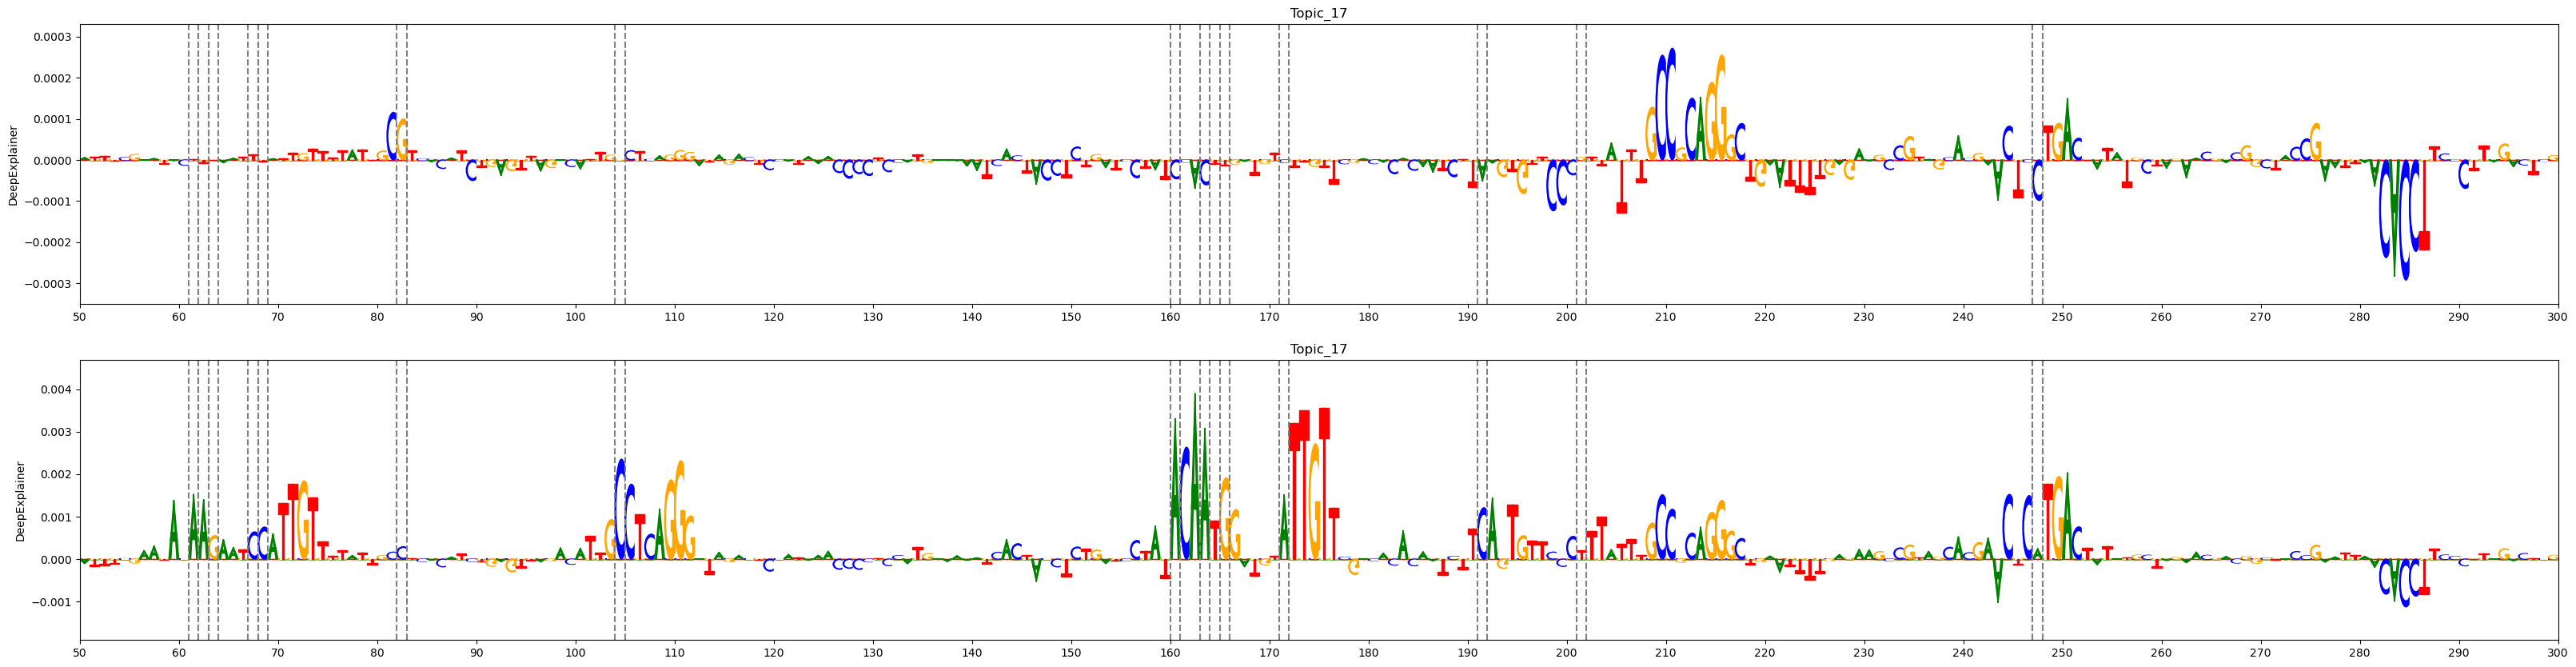

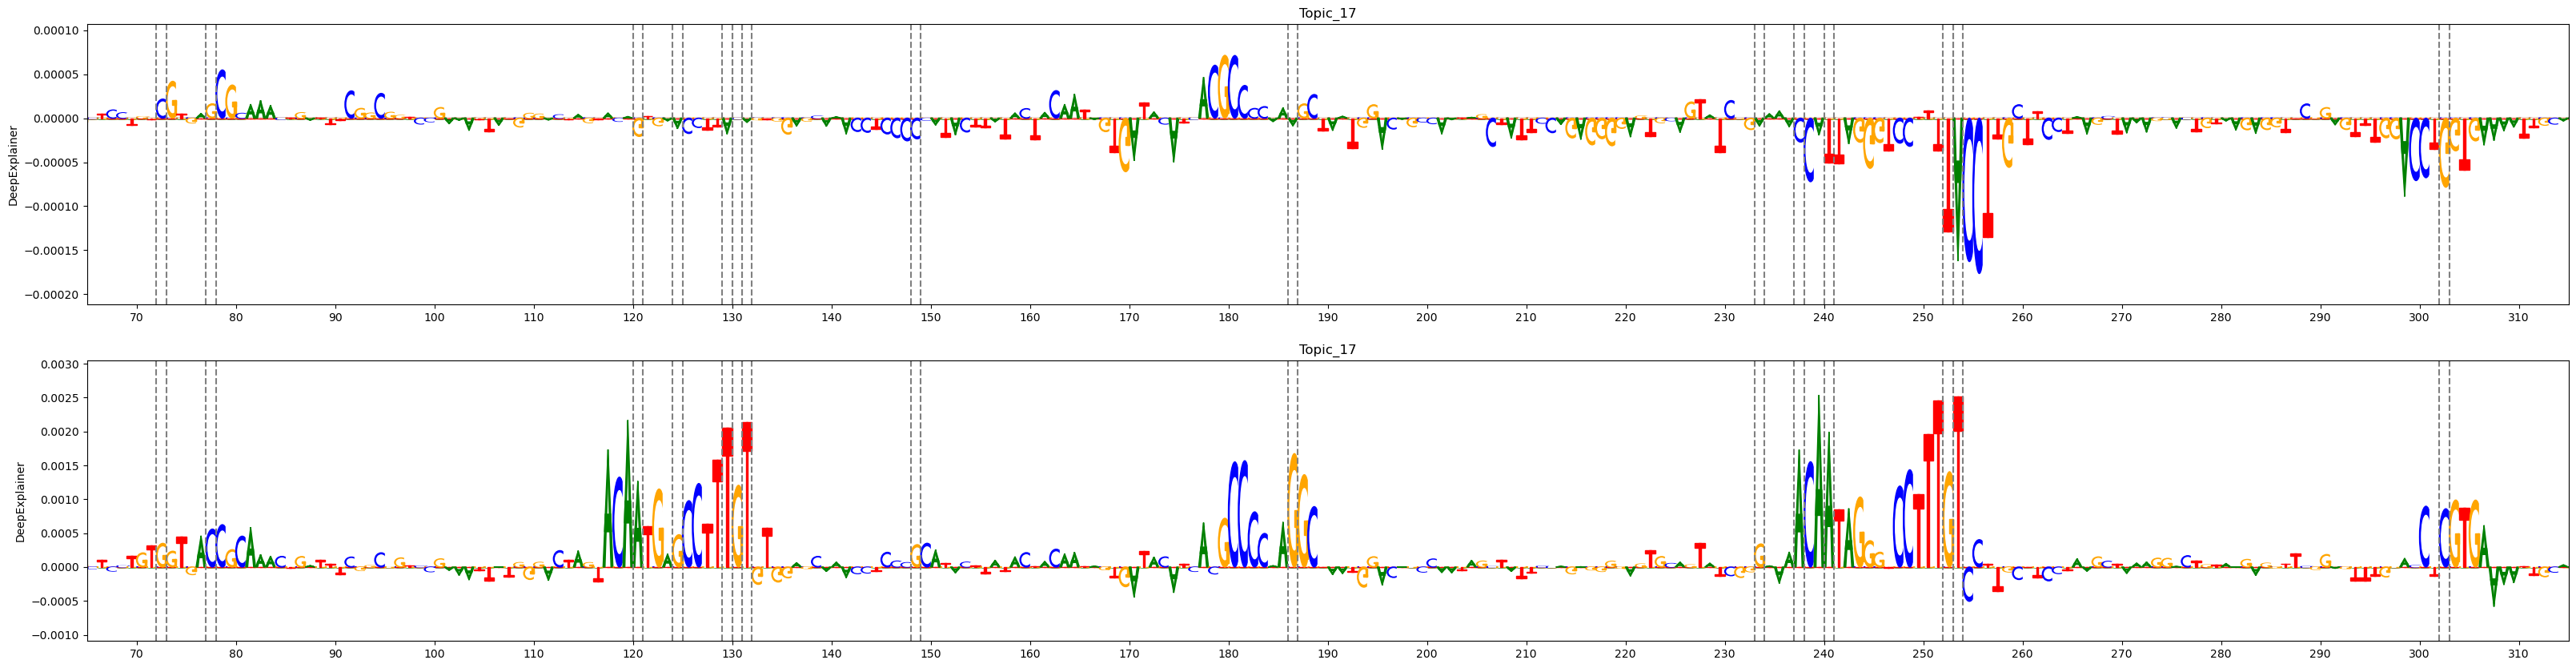

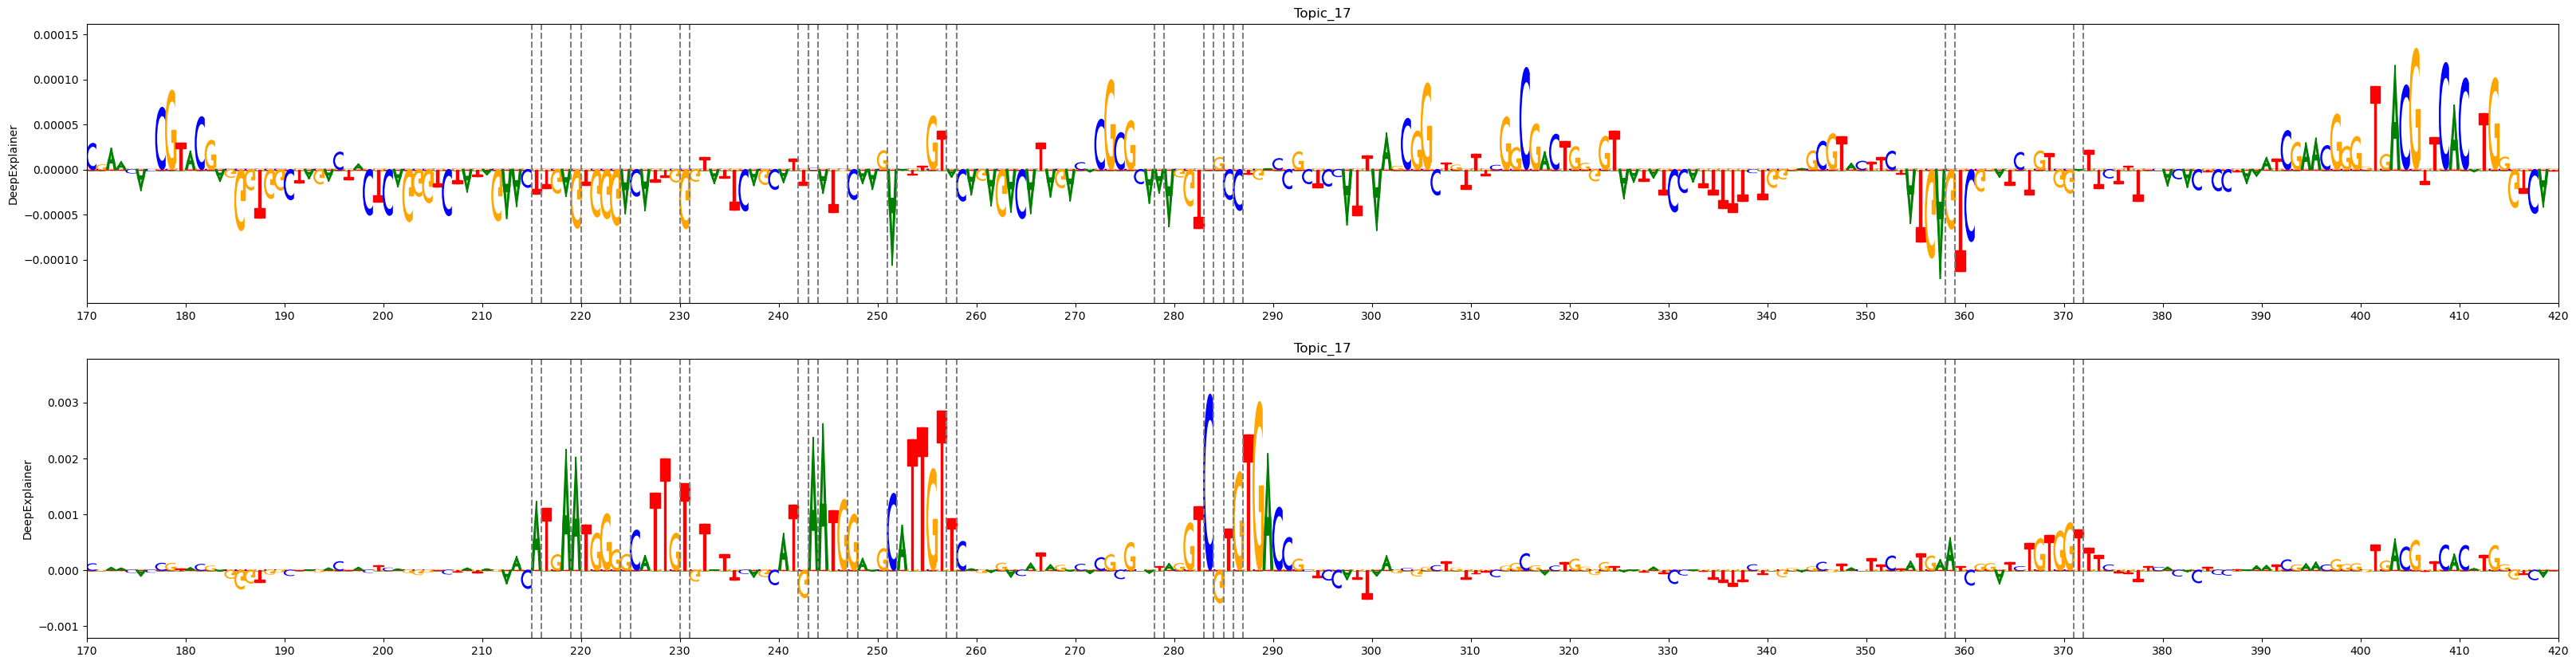

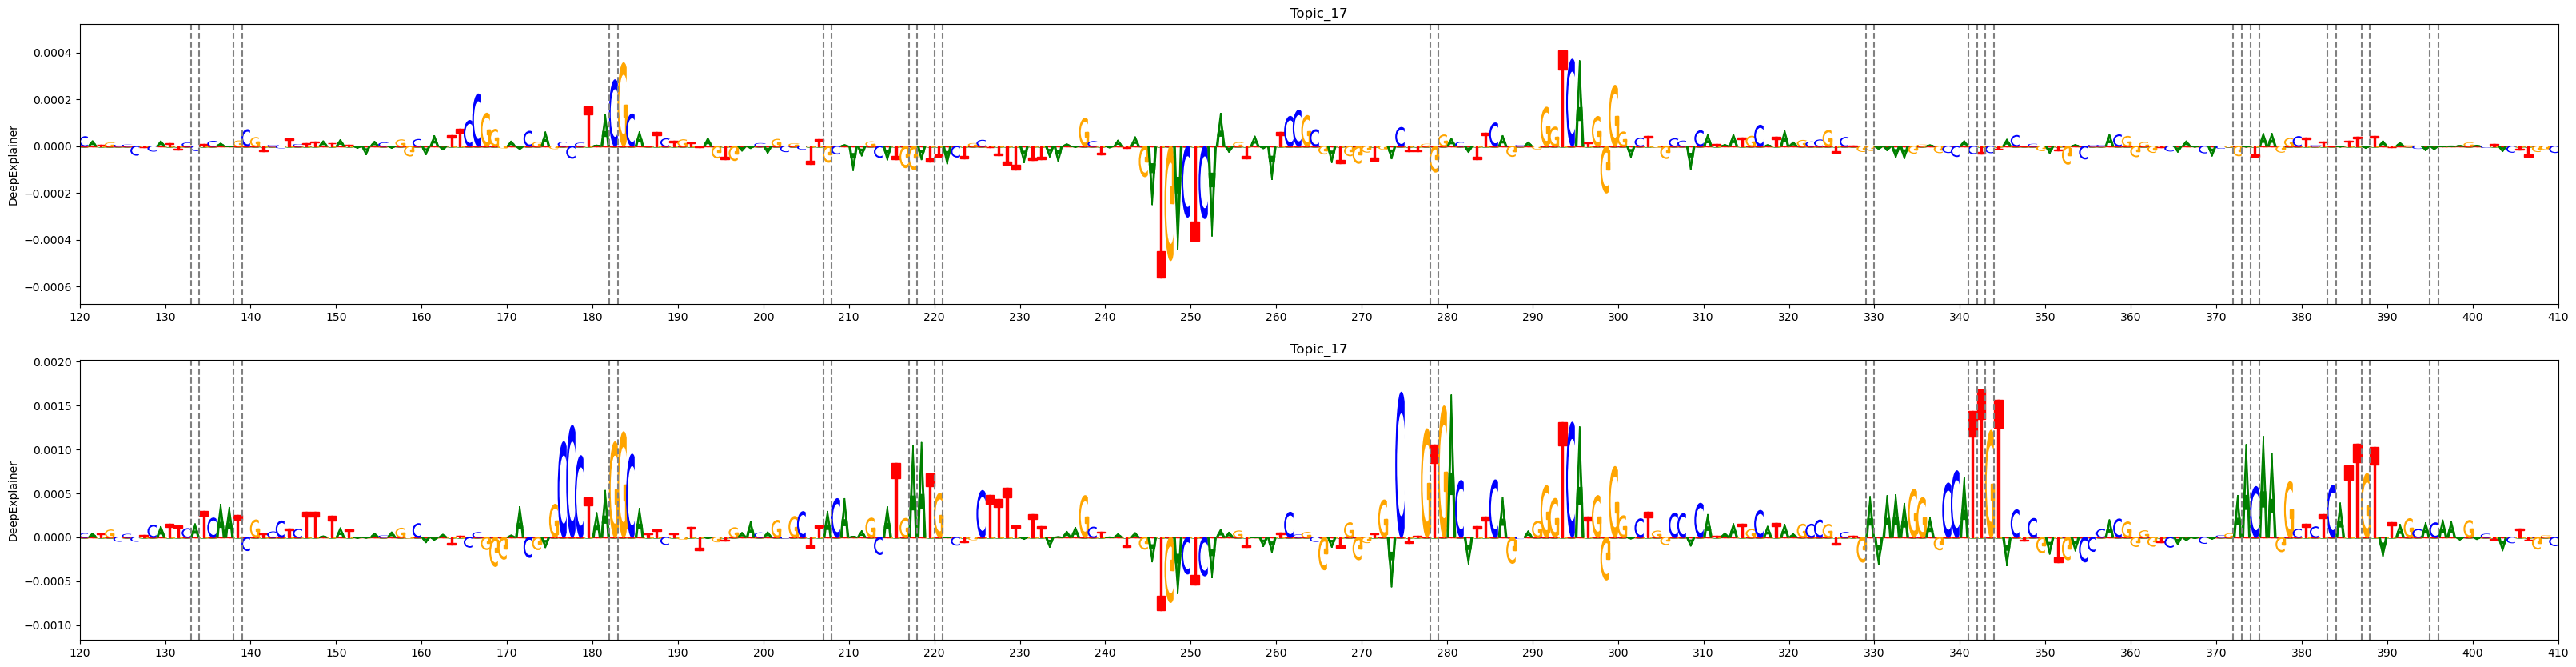

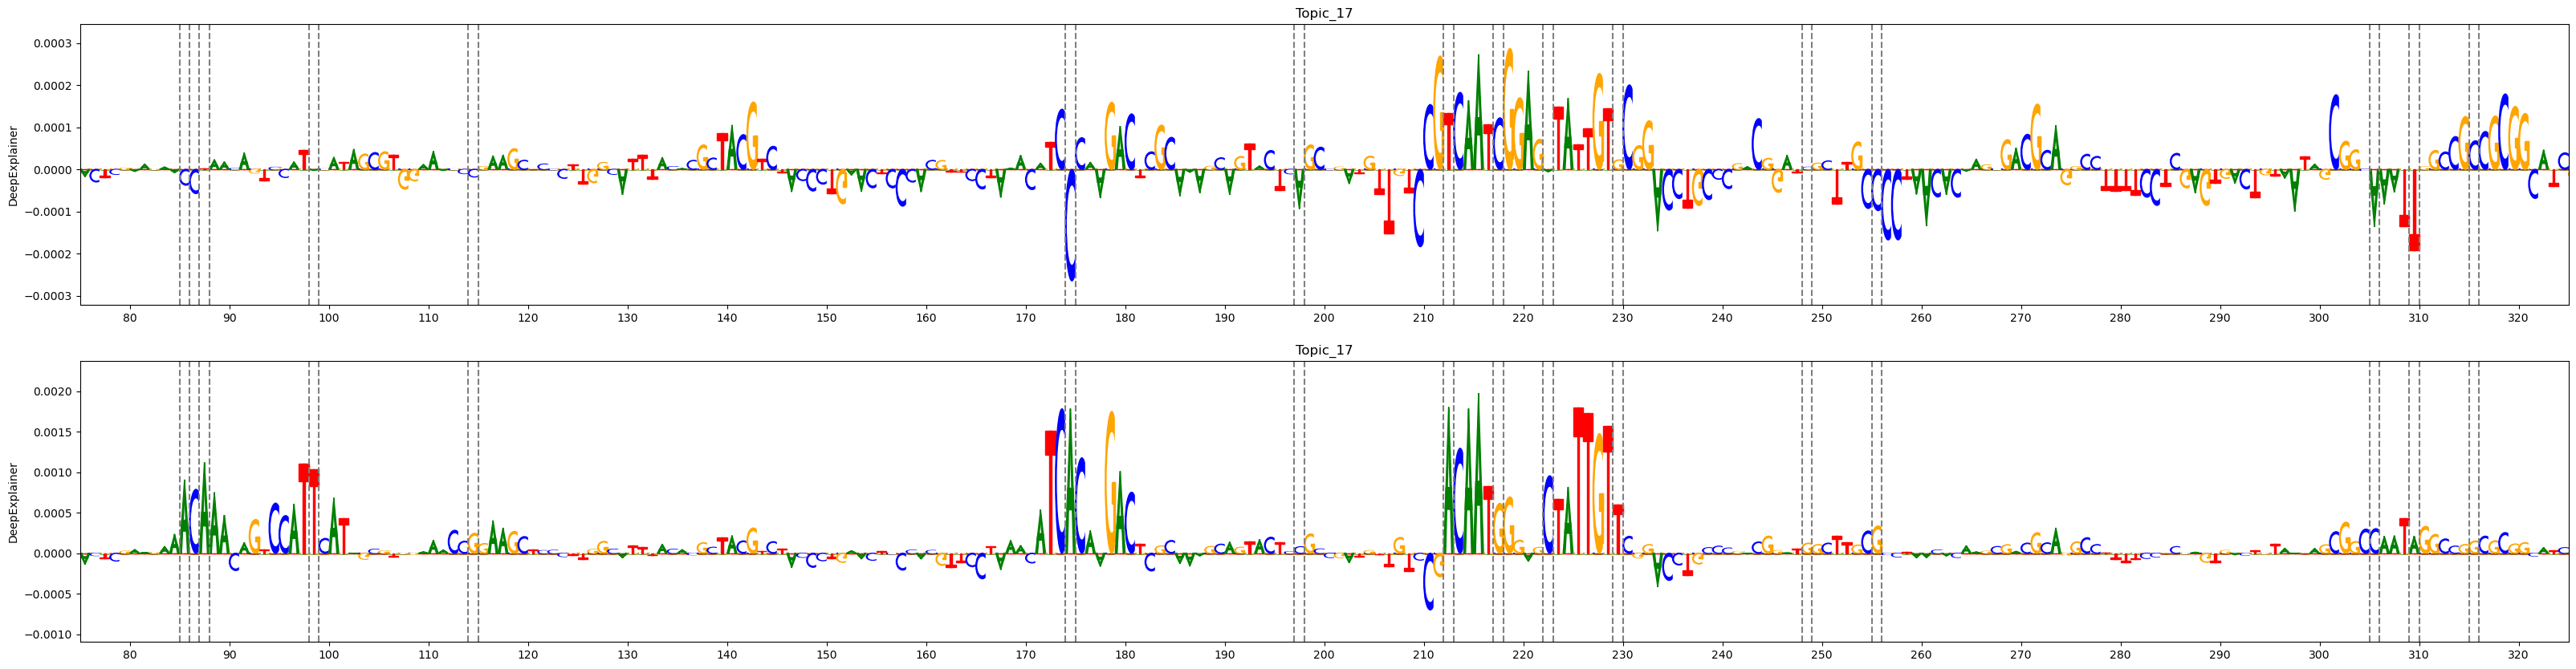

In [34]:
#[15,17,19,22,27,45,49,60,68,72]
locs = [[250,500],
        [210,460],
        [200,450],
        [90,340],
        [235,460],
        [50,300],
        [65,315],
        [170,420],
        [120,410],
        [75,325]]
for k,id_ in enumerate([15,17,19,22,27,45,49,60,68,72]):
    
    st = locs[k][0]
    end = locs[k][1]

    nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}
    start_x = np.copy(evolved_seq_4000_dict["X"][id_:id_+1])

    ntrack = 2
    fig = plt.figure(figsize=(40,ntrack*5))
    ax1 = utils.plot_deepexplainer_givenax_withrc(explainer=exp_dict["deepmel2"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 17)

    for i, mut_ in enumerate(evolved_seq_4000_dict["mut_loc"][id_][:15]):
        start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')

    ax2 = utils.plot_deepexplainer_givenax_withrc(explainer=exp_dict["deepmel2"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 17)

    for i, mut_ in enumerate(evolved_seq_4000_dict["mut_loc"][id_][:15]):

        start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
        ax1.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
        ax1.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
        ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
        ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

    ax1.set_xlim([st,end])
    ax2.set_xlim([st,end])


    plt.savefig("figures/evolution_from_scratch/EFS"+str(k+1)+"_deepexplainer_mut0_mut15_st"+str(st)+"_end"+str(end)+"_topic17.pdf",transparent=True)

### Printing generated DNA sequences in nucleotide letters.

In [54]:
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

for id_ in [15,17,19,22,27,45,49,60,68,72]: 

    start_x = np.copy(evolved_seq_4000_dict["X"][id_:id_+1])

    for i, mut_ in enumerate(evolved_seq_4000_dict["mut_loc"][id_]):
        if i>=15:
            break 
        start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')

    print(">id"+str(id_)+"_mut15")

    for nuc in start_x[0]:
        if nuc[0]==1:
            print("A",end="")
        if nuc[1]==1:
            print("C",end="")
        if nuc[2]==1:
            print("G",end="")
        if nuc[3]==1:
            print("T",end="")
    print("")


>id15_mut15
CTGATTGTTTGAACCATTGTTACGATTTGGTAGCGAGGCCCATTTTTTAGAATTCGGGACCTCTTAGACAGGGTCCAAAGCATTTGAACTGATCGGTCTATCCGGTTATGACCGGTCTTAAACTCCGCTCACGAAAGTCACTGGGTCATAGCTGTATCTAACGTCCCCTGACGTTGTACGTTTCCGATTGTCGGTGAGCTTTAACAACAGCCAGTCGTGCAGAATTCGGAAAAAGACTTTGGGTATATCTAGCGAACAGAAATGAGTGACATTTCGTTACAACTAGTGTCGGGAACAATGCCCTCACTGAAGCTACATGAATAGGCCCTTTGTATTCGTGGGTGTGGTACCACGTGGCGTGCGTCTACCGTGGGGACAAAGAGCTCTTTTAATGGAAATTGCGCTTCCCACATCGCGAGGAGGATCTGTAAGGGTGAGCGAGACCGTGTTGGACACACCACACGTTTACGGTATGAGTCACGCGCAAAAAACAAAATTGC
>id17_mut15
GCCGAGTACTGTATTAACACGCAAACGGTATGTTGCTGAACTTTACCGTCAAACGCCTCTGGTTTTACGAGTCCACTGATGACGTACATACAGTCCGATCTTGGAAAGACTTCCTCGCTGTCTTGAGAAGATGCCGGTCTTATTTGCTTTGGGACTTTGGGCTCACGTAAGTAATCCTCAGTCCCTTTAATGTGCTCTTACGGATCTTCACAAGTGAGGTGCCGGTTCCATACCTACTGAAAGAGGCTATTCATTACCGCTCGCTGCCACGCATGGTCACGAGTTTCCCCCAGGCAGTATCAACAATGAAAGCATTGAACCGACCGAGAGTGCGGGAACAGGGTCGCGGGTGCGTGGGAAGGTAGGAAAGGGGTCGGCGGTACATTTTACTGAAAGAAGAGAAGGTCTTGGGGCCTTCCGCTAAGATAACTGCAAACGACAGGGCTCCGGCCCCAATTCCATGTTGGACCTTTAT